# Imports
Aqui eu só dou import em todas as partes importantes do código. Tenho que revisar pois acho que tem coisas que eu não uso de fato. Nota que os 3 ultimos imports são imports dos gráficos usados na resolução do problema usando a Adaline.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
torch.manual_seed(0)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
print(torch.version.cuda)
print(torch.cuda.is_available())

None
False


# Modelo CNN
## O que cada coisa faz?
Conv2d: Primeiro ele extrai os padrões uysando um kernel size de 3x3. Aplica numa área 3x3 e vai pegando os padrões da borda/cantos.

AvgPool2d: reduz resolução (downsampling) pegando a média do 2x2.

BatchNorm: Estabiliza o treino.

Sigmoid: Função de ativação sigmoide. (Perguntar o que é a SILU e se era pra usar)

Obs: Esse valor de 1600 no MLP pelo valor que o tensor fica no final. A lógica é que ele passa pelo Conv2d e acaba multiplicando os fatores por uma formula e ganha números a mais a cada dimensão. Aí ele passa pelo batch e fica menor. Fazendo com que a dimensão dos dois ultimos algarismos fique menos mas a primeira continua grande. Ou seja, usando a formula de tamanho espacial, isso fica (28-3+0)/1+1=26 ao passar no primeiro bloco, então o tensor tem tamanho de (32,26,26), passa pelo Batch e reduz as dimensões em dois sem ser a informação adquirida da Conv2d, ficando (32,13,13) e resultando no final em uma saída de 32 * 13 * 13 = 5408.

In [2]:
class ModeloMNIST(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.bloco1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), bias=True),
            nn.MaxPool2d(kernel_size=(2, 2)), # Aqui eu to usando MaxPool que é pegar o maximo, nesse caso, de um quadrado 2d. Eu poderia usar o average(média do quadrado) ou o min
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32),
        )
        self.bloco2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), bias=True),
            nn.MaxPool2d(kernel_size=(2, 2)), # Aqui eu to usando MaxPool que é pegar o maximo, nesse caso, de um quadrado 2d. Eu poderia usar o average(média do quadrado) ou o min
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=1600, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=10),
        )
    def forward(self, dados: torch.Tensor) -> torch.Tensor:
        saida = self.bloco1(dados)
        saida = self.bloco2(saida)
        saida = self.mlp(saida.flatten(1))
        return saida

In [3]:
class TreinandoMNIST:
    def __init__(self):
        self.tamanhoBatch = 32
        self.embaralhar = True
        #self.workers = 0
        self.lr = 0.002
        self.epocas = 4
        self.dispositivo = torch.device("cpu")
        
        self.historicoLoss = []
        self.historicoAcc = []

        self.inicializarDataset()
        self.inicializarModelo()
            
    def inicializarDataset(self):
        # transformando os valores em 0 e 1 e em tensores. ou seja, agora terei uma imagem (x, 0/1, 0/1) a cada pixel.
        transf = Compose([ToTensor(), Normalize(mean=(0.1307,), std=(0.3081,))])
        
        dsTreino = MNIST(root="dataset", train=True, download=True, transform=transf)
        
        self.loaderTreino = DataLoader(
            dsTreino, 
            batch_size=self.tamanhoBatch, 
            shuffle=self.embaralhar, 
        )
        
        dsTeste = MNIST(root="dataset", train=False, download=True, transform=transf)
        self.loaderTeste = DataLoader(
            dsTeste,
            batch_size=self.tamanhoBatch,
            shuffle=False,
        )

    def inicializarModelo(self):
        self.modelo = ModeloMNIST()
        self.modelo.to(self.dispositivo)
        self.criterio = nn.CrossEntropyLoss()
        #self.criterio = nn.MSELoss()

        # parametro - lr * gradiente// Perguntar para Leonardo se era pra eu usar o otimizador ou fazer na mao a atualização dos pesos
        
        # self.otimizador = optim.AdamW(
        #     self.modelo.parameters(), 
        #     lr=self.lr, 
        #     # weight decay entraria aqui mas por que eu botaria ele e como que ele funciona
        # )

    def treinar(self):
        print("Treinando...\n\n")
        self.modelo.train()
        
        for epoca in range(self.epocas):
            perdaCorrente = 0.0
            for idx, (imagens, rotulos) in enumerate(self.loaderTreino):
                imagens, rotulos = imagens.to(self.dispositivo), rotulos.to(self.dispositivo)
                
                #zerando gradiente, se eu usar optimizerAdam aqui é optimizer e usa o optimizer/inicializa ele la em cima
                self.modelo.zero_grad()
                
                saidas = self.modelo(imagens)
                
                # one hot pro mse
                #rotulosOneHot = F.one_hot(rotulos, num_classes=10).float()
                
                #se eu quiser testar dnv o crossEntropy, er so colocar rotulos auqi ao inves de rotulos one hot e rodar
                perda = self.criterio(saidas, rotulos)
                perda.backward()
                
                # fazendo a atualização manual
                with torch.no_grad():
                    for param in self.modelo.parameters():
                            # w = w - learning_rate * gradiente
                            param -= self.lr * param.grad

                perdaCorrente += perda.item()
                
                # a cada 50 passos ele faz um log
                if idx % 50 == 49:
                    mediaPerda = perdaCorrente / 50
                    
                    _, predicoes = torch.max(saidas, 1)
                    AcuraciaBatch = (predicoes == rotulos).float().mean().item()
                    
                    self.historicoLoss.append(mediaPerda)
                    self.historicoAcc.append(AcuraciaBatch)


                    print(f"Época {epoca+1} | Passos: {idx + 1:<4} | Perda: {mediaPerda:.3f} | Acurácia Batch: {AcuraciaBatch:.3f}")
                    perdaCorrente = 0.0
        

    def avaliar(self):
        print("Avaliação:\n\n")
        self.modelo.eval()
        
        reais = []
        previstos = []
        imagensTeste = [] 

        with torch.no_grad():
            for imagens, rotulos in self.loaderTeste:
                imagensGpu = imagens.to(self.dispositivo)
                saida = self.modelo(imagensGpu)
                _, previsao = torch.max(saida.data, 1)

                previstos.extend(previsao.cpu().numpy())
                reais.extend(rotulos.numpy()) 
                imagensTeste.append(imagens.numpy()) 

        # numpy
        self.XTest = np.concatenate(imagensTeste)
        self.yReal = np.array(reais)
        self.yPred = np.array(previstos)

        acuracia = accuracy_score(self.yReal, self.yPred)
        self.precision, self.recall, self.fscore, _ = precision_recall_fscore_support(self.yReal, self.yPred, average="macro")
        _, _, self.fscoreC, _ = precision_recall_fscore_support(self.yReal, self.yPred, average=None)
        
        print(f"{acuracia=:.3f}")
        print(f"{self.precision=:.3f}")
        print(f"{self.recall=:.3f}")
        print(f"{self.fscore=:.3f}")

        print(f"Acurácia Final no Teste: {acuracia:.3f}")

    def plotarResultados(self):
        print("--- Gerando Gráficos ---")
        plt.figure(figsize=(15, 12))

        plt.subplot(3, 2, 1)
        plt.plot(self.historicoLoss, label='Erro (MSE)', color='blue', linewidth=2)
        plt.title("Redução do Erro (Treino)")
        plt.xlabel("Iterações (x50)")
        plt.ylabel("Erro")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 2, 2)
        plt.plot(self.historicoAcc, label='Acurácia', color='orange', linewidth=2)
        plt.title("Aumento da Acurácia (Treino)")
        plt.xlabel("Iterações (x50)")
        plt.ylabel("Taxa de Acerto")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(3, 2, 3)
        cm = confusion_matrix(self.yReal, self.yPred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title("Matriz de Confusão (Teste)")
        plt.ylabel("Real")
        plt.xlabel("Previsto")

        plt.subplot(3, 2, 4)
        classes = [str(i) for i in range(10)]
        plt.bar(classes, self.fscoreC, color='purple', alpha=0.7)
        plt.title("F1-Score por Dígito (Teste)")
        plt.xlabel("Dígito")
        plt.ylabel("F1-Score")
        plt.ylim(0, 1.1)
        plt.grid(axis='y', alpha=0.3)
        plt.grid(axis='y', alpha=0.3)
        for i, v in enumerate(self.fscoreC):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)

        rng = np.random.default_rng()
        nSamples = min(len(self.XTest), 6)
        indicesTeste = rng.choice(len(self.XTest), nSamples, replace=False)

        for i, idx in enumerate(indicesTeste):
            plt.subplot(3, 6, 13 + i)
            img = self.XTest[idx].reshape(28, 28)
            pred = self.yPred[idx]
            real = self.yReal[idx]
            
            plt.imshow(img, cmap='gray')
            cor = 'green' if pred == real else 'red'
            plt.title(f"P: {pred} / R: {real}", color=cor, fontweight='bold')
            plt.axis('off')

        plt.tight_layout()
        plt.show()


Treinando...


Época 1 | Passos: 50   | Perda: 2.189 | Acurácia Batch: 0.469
Época 1 | Passos: 100  | Perda: 1.853 | Acurácia Batch: 0.500
Época 1 | Passos: 150  | Perda: 1.492 | Acurácia Batch: 0.781
Época 1 | Passos: 200  | Perda: 1.158 | Acurácia Batch: 0.844
Época 1 | Passos: 250  | Perda: 0.953 | Acurácia Batch: 0.844
Época 1 | Passos: 300  | Perda: 0.757 | Acurácia Batch: 0.875
Época 1 | Passos: 350  | Perda: 0.668 | Acurácia Batch: 0.938
Época 1 | Passos: 400  | Perda: 0.567 | Acurácia Batch: 0.875
Época 1 | Passos: 450  | Perda: 0.490 | Acurácia Batch: 0.906
Época 1 | Passos: 500  | Perda: 0.459 | Acurácia Batch: 0.938
Época 1 | Passos: 550  | Perda: 0.405 | Acurácia Batch: 0.844
Época 1 | Passos: 600  | Perda: 0.395 | Acurácia Batch: 0.938
Época 1 | Passos: 650  | Perda: 0.342 | Acurácia Batch: 0.938
Época 1 | Passos: 700  | Perda: 0.337 | Acurácia Batch: 0.875
Época 1 | Passos: 750  | Perda: 0.304 | Acurácia Batch: 0.969
Época 1 | Passos: 800  | Perda: 0.284 | Acurácia Batch:

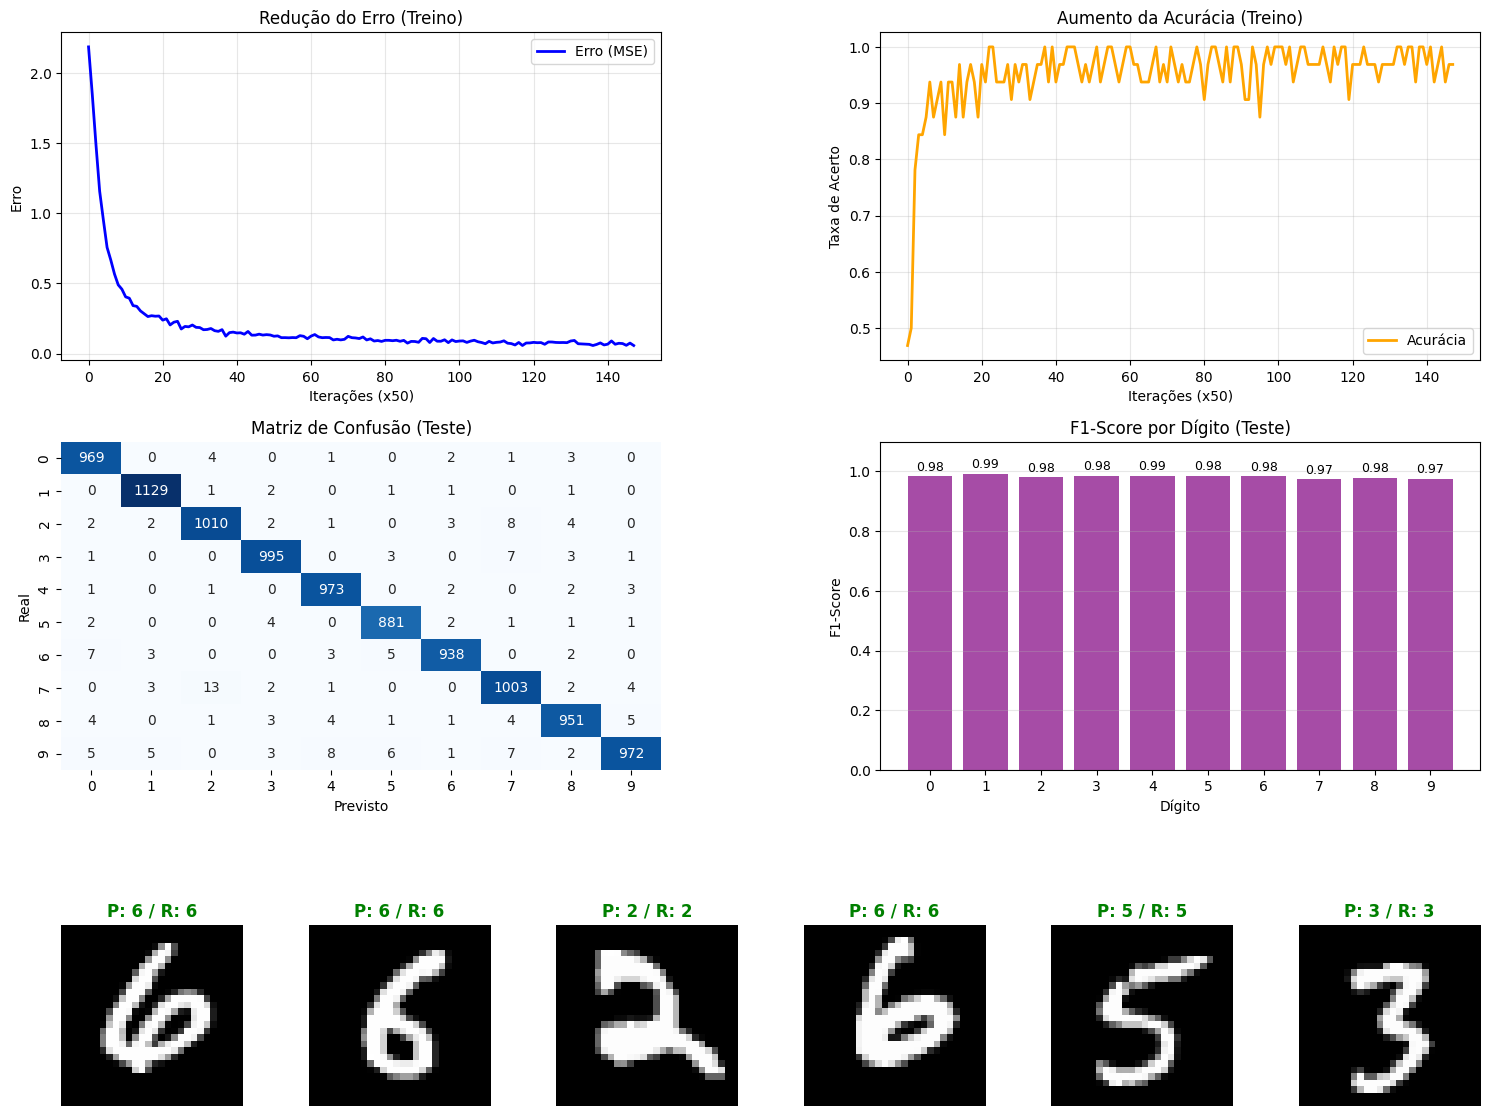

In [4]:

if __name__ == "__main__":
    CNN = TreinandoMNIST()
    CNN.treinar()
    CNN.avaliar()
    CNN.plotarResultados()

# -Utilizando Sigmoide---------------------------------
### •Com MSE e ONE HOT;
&emsp; Usando Adam Optimizer o resultado varia de 94% até 99%. 
&emsp; Usando atualização manual dos pesos com 32 neurônios: Min de 78%(5) e Max de 92%(1). Utilizando 128 neurônios: Min 83% e Max de 94%. Média de 89,3%
### •Com CROSS-ENTROPY/Entropia cruzada 
&emsp; Usando atualização manual dos pesos com 32 neurônios: 94%(4) até 99%(2). Média de 94,9%. Utilizando 128 neurônios: Média de 95% ou seja, sem mudança subtancial.

# -Utilizando ReLU/Rectifiec linear unit---------------
### •Com MSE e ONE HOT
&emsp; Usando atualização manual dos pesos com 32 neurônios: Média de 94,9%. 
### •Com CROSS-ENTROPY/Entropia cruzada
&emsp; Usando atualização manual dos pesos com 32 neurônios: Média de 98%.